## Loading Data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_set, valid_set = torch.utils.data.random_split(train_dataset, [40000, 10000])
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

## Training and Testing Utils

In [5]:
import time
from tqdm import tqdm

In [6]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10, device='cpu'):
    model.to(device)

    train_loss_history = []
    train_accuracy_history = []
    
    valid_loss_history = []
    valid_accuracy_history = []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()

        train_loss, train_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            predicted = outputs.argmax(dim=1)
            train_corrects += (predicted == labels).sum().item()
    
        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_corrects / len(train_loader.dataset)

        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        
        model.eval()
        
        valid_loss, valid_corrects = 0.0, 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc=f'Epoch {epoch+1}/{epochs}'):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                predicted = outputs.argmax(dim=1)
                valid_corrects += (predicted == labels).sum().item()
        
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_accuracy = valid_corrects / len(valid_loader.dataset)
        
        valid_loss_history.append(valid_loss)
        valid_accuracy_history.append(valid_accuracy)
        
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        print(f'Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}')
    
    end_time = time.time()

    print(f'Finished Training. Total Training Time: {end_time - start_time:.2f} seconds.')

    return train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history

In [7]:
def test_model(model, test_loader, criterion, device='cpu'):
    model.to(device)
    model.eval()
    
    test_loss, test_corrects = 0.0, 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            
            predicted = outputs.argmax(dim=1)
            test_corrects += (predicted == labels).sum().item()
        
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = test_corrects / len(test_loader.dataset)
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%')
    
    return test_loss, test_accuracy

## Loading Models

In [8]:
from models import lnn, cnn
from matplotlib import pyplot as plt

#### Linear Neural Network

In [9]:
lnn_model = lnn.LNN(32 * 32 * 3, num_classes=10)

num_params = sum([p.numel() for p in lnn_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  33475330


In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lnn_model.parameters(), lr=0.001)

train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = train_model(lnn_model, train_loader, valid_loader, criterion, optimizer, epochs=60, device='cuda')

Epoch 1/60: 100%|██████████| 1250/1250 [00:17<00:00, 70.17it/s]


Train Loss: 1.7764, Train Accuracy: 0.3657


Epoch 1/60: 100%|██████████| 313/313 [00:00<00:00, 366.02it/s]


Valid Loss: 1.6552, Valid Accuracy: 0.4176


Epoch 2/60: 100%|██████████| 1250/1250 [00:17<00:00, 69.93it/s]


Train Loss: 1.5552, Train Accuracy: 0.4502


Epoch 2/60: 100%|██████████| 313/313 [00:00<00:00, 382.53it/s]


Valid Loss: 1.5681, Valid Accuracy: 0.4529


Epoch 3/60:  16%|█▌        | 196/1250 [00:02<00:15, 67.62it/s]


KeyboardInterrupt: 

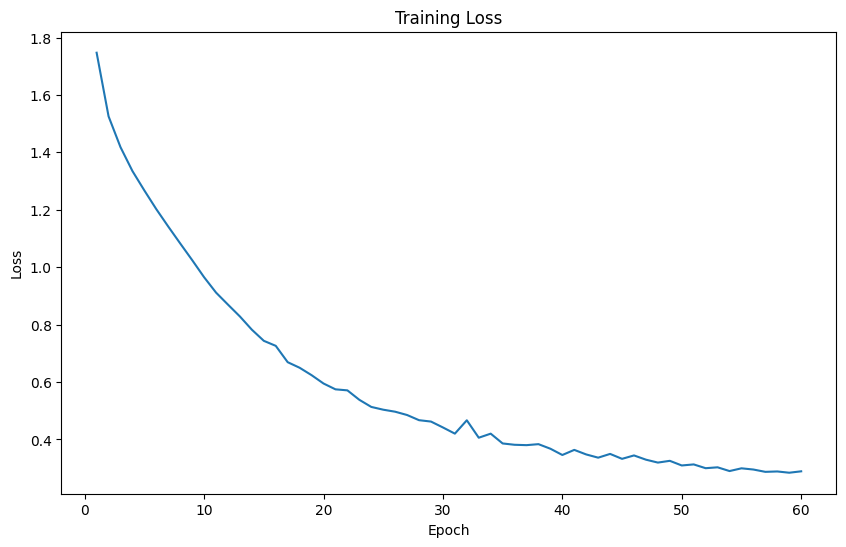

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label='Validation Loss')
plt.title('Training & Validation Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

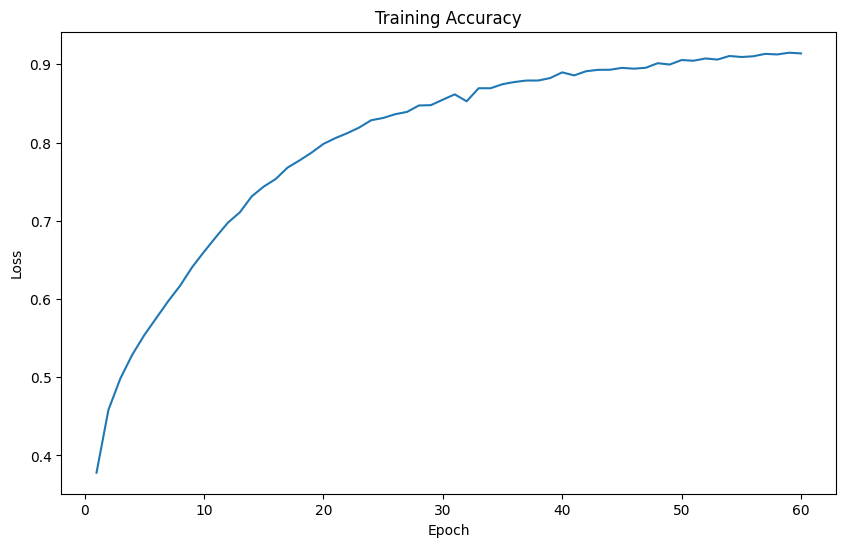

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history, label='Training Accuracy')
plt.plot(range(1, len(valid_accuracy_history) + 1), valid_accuracy_history, label='Validation Accuracy')
plt.title('Training & Validation Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [ ]:
test_model(lnn_model, test_loader, criterion, device='cuda')

Test Loss: 3.0048, Accuracy: 0.5339%


#### Convolutional Neural Network

In [ ]:
cnn_model = cnn.CNN(3, num_classes=10)

num_params = sum([p.numel() for p in cnn_model.parameters()])
print("Number of parameters: ", num_params)

Number of parameters:  1107538


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

train_loss_history, train_accuracy_history, valid_loss_history, valid_accuracy_history = train_model(cnn_model, train_loader, valid_loader, criterion, optimizer, epochs=30, device='cuda')

Epoch 1/30: 100%|██████████| 1563/1563 [00:06<00:00, 227.13it/s]


Train Loss: 1.2342, Train Accuracy: 0.5527


Epoch 2/30: 100%|██████████| 1563/1563 [00:06<00:00, 231.99it/s]


Train Loss: 0.8049, Train Accuracy: 0.7156


Epoch 3/30: 100%|██████████| 1563/1563 [00:06<00:00, 232.72it/s]


Train Loss: 0.6517, Train Accuracy: 0.7708


Epoch 4/30: 100%|██████████| 1563/1563 [00:06<00:00, 231.42it/s]


Train Loss: 0.5467, Train Accuracy: 0.8073


Epoch 5/30: 100%|██████████| 1563/1563 [00:06<00:00, 231.35it/s]


Train Loss: 0.4678, Train Accuracy: 0.8347


Epoch 6/30: 100%|██████████| 1563/1563 [00:06<00:00, 236.32it/s]


Train Loss: 0.4009, Train Accuracy: 0.8583


Epoch 7/30: 100%|██████████| 1563/1563 [00:07<00:00, 222.99it/s]


Train Loss: 0.3385, Train Accuracy: 0.8812


Epoch 8/30: 100%|██████████| 1563/1563 [00:06<00:00, 229.98it/s]


Train Loss: 0.2850, Train Accuracy: 0.8993


Epoch 9/30: 100%|██████████| 1563/1563 [00:06<00:00, 230.93it/s]


Train Loss: 0.2356, Train Accuracy: 0.9158


Epoch 10/30: 100%|██████████| 1563/1563 [00:06<00:00, 229.00it/s]


Train Loss: 0.2034, Train Accuracy: 0.9271


Epoch 11/30: 100%|██████████| 1563/1563 [00:06<00:00, 236.49it/s]


Train Loss: 0.1652, Train Accuracy: 0.9412


Epoch 12/30: 100%|██████████| 1563/1563 [00:06<00:00, 237.45it/s]


Train Loss: 0.1439, Train Accuracy: 0.9485


Epoch 13/30: 100%|██████████| 1563/1563 [00:06<00:00, 235.35it/s]


Train Loss: 0.1235, Train Accuracy: 0.9557


Epoch 14/30: 100%|██████████| 1563/1563 [00:06<00:00, 241.79it/s]


Train Loss: 0.1118, Train Accuracy: 0.9607


Epoch 15/30: 100%|██████████| 1563/1563 [00:06<00:00, 233.60it/s]


Train Loss: 0.0964, Train Accuracy: 0.9662


Epoch 16/30: 100%|██████████| 1563/1563 [00:06<00:00, 239.09it/s]


Train Loss: 0.0918, Train Accuracy: 0.9686


Epoch 17/30: 100%|██████████| 1563/1563 [00:06<00:00, 234.28it/s]


Train Loss: 0.0845, Train Accuracy: 0.9706


Epoch 18/30: 100%|██████████| 1563/1563 [00:06<00:00, 232.99it/s]


Train Loss: 0.0756, Train Accuracy: 0.9735


Epoch 19/30: 100%|██████████| 1563/1563 [00:06<00:00, 235.23it/s]


Train Loss: 0.0771, Train Accuracy: 0.9738


Epoch 20/30: 100%|██████████| 1563/1563 [00:06<00:00, 239.55it/s]


Train Loss: 0.0662, Train Accuracy: 0.9773


Epoch 21/30: 100%|██████████| 1563/1563 [00:07<00:00, 220.56it/s]


Train Loss: 0.0652, Train Accuracy: 0.9778


Epoch 22/30: 100%|██████████| 1563/1563 [00:07<00:00, 220.78it/s]


Train Loss: 0.0640, Train Accuracy: 0.9781


Epoch 23/30: 100%|██████████| 1563/1563 [00:07<00:00, 219.74it/s]


Train Loss: 0.0557, Train Accuracy: 0.9803


Epoch 24/30: 100%|██████████| 1563/1563 [00:07<00:00, 214.72it/s]


Train Loss: 0.0569, Train Accuracy: 0.9803


Epoch 25/30: 100%|██████████| 1563/1563 [00:07<00:00, 211.27it/s]


Train Loss: 0.0557, Train Accuracy: 0.9809


Epoch 26/30: 100%|██████████| 1563/1563 [00:07<00:00, 202.11it/s]


Train Loss: 0.0481, Train Accuracy: 0.9835


Epoch 27/30: 100%|██████████| 1563/1563 [00:07<00:00, 220.16it/s]


Train Loss: 0.0491, Train Accuracy: 0.9832


Epoch 28/30: 100%|██████████| 1563/1563 [00:06<00:00, 226.77it/s]


Train Loss: 0.0482, Train Accuracy: 0.9835


Epoch 29/30: 100%|██████████| 1563/1563 [00:06<00:00, 234.78it/s]


Train Loss: 0.0468, Train Accuracy: 0.9838


Epoch 30/30: 100%|██████████| 1563/1563 [00:07<00:00, 218.49it/s]

Train Loss: 0.0444, Train Accuracy: 0.9846
Finished Training. Total training time: 205.49 seconds.


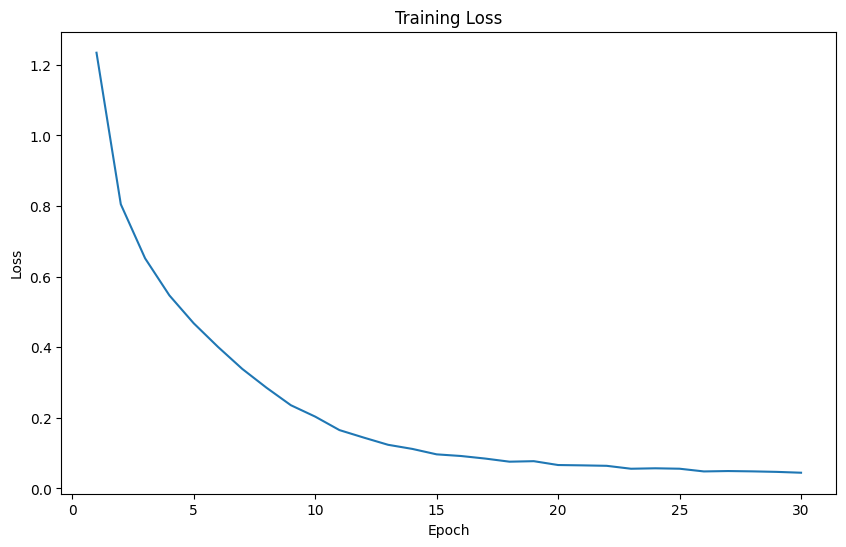

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, len(valid_loss_history) + 1), valid_loss_history, label='Validation Loss')
plt.title('Training & Validation Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

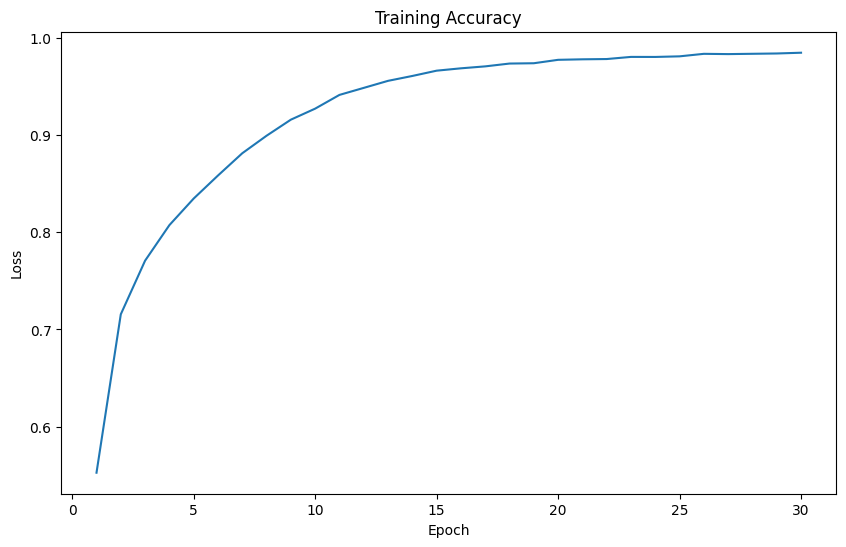

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracy_history) + 1), train_accuracy_history, label='Training Accuracy')
plt.plot(range(1, len(valid_accuracy_history) + 1), valid_accuracy_history, label='Validation Accuracy')
plt.title('Training & Validation Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [ ]:
test_model(cnn_model, test_loader, criterion, device='cuda')

Test Loss: 1.1848, Accuracy: 0.8006%
